<a href="https://colab.research.google.com/github/AnuhyaTirukatchi/project/blob/main/Code_A_Deep_Learning_Approach_for_Multi_Class_Classification_of_Chest_X_Rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/Covid19-Pneumonia-Normal Chest X-Ray Images Dataset"
folders = os.listdir(base_dir)

file_path = []
labels = []

for folder in folders:
    sub_folder = os.path.join(base_dir, folder)
    sub_list = os.listdir(sub_folder)
    for file in sub_list:
        f_path = os.path.join(sub_folder, file)
        file_path.append(f_path)
        labels.append(folder)

df = pd.DataFrame({'file_path': file_path, 'labels': labels})
df.head()

,file_path,labels
0,/content/drive/MyDrive/Colab Notebooks/Covid19...,COVID
1,/content/drive/MyDrive/Colab Notebooks/Covid19...,COVID
2,/content/drive/MyDrive/Colab Notebooks/Covid19...,COVID
3,/content/drive/MyDrive/Colab Notebooks/Covid19...,COVID
4,/content/drive/MyDrive/Colab Notebooks/Covid19...,COVID


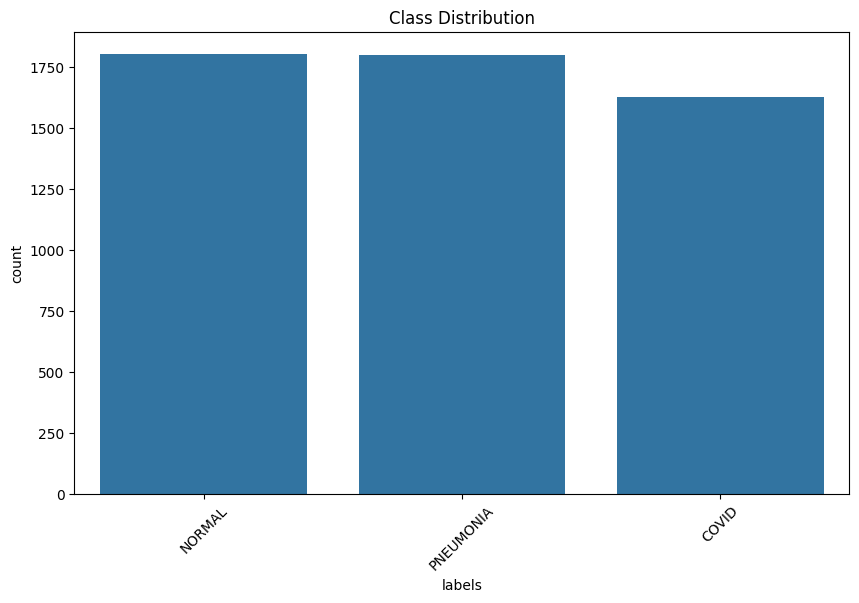

In [4]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

             width       height
count  5228.000000  5228.000000
mean    236.590666   236.590666
std       9.440276     9.440276
min     232.000000   232.000000
25%     232.000000   232.000000
50%     232.000000   232.000000
75%     232.000000   232.000000
max     256.000000   256.000000


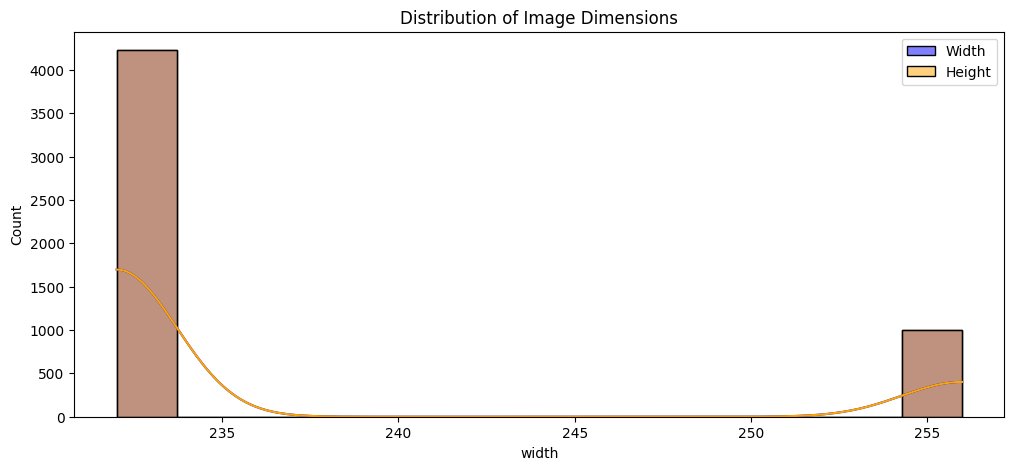

In [5]:
from PIL import Image

img_dimensions = []
for path in df['file_path']:
    with Image.open(path) as img:
        img_dimensions.append(img.size)

df['dimensions'] = img_dimensions
df['width'] = df['dimensions'].apply(lambda x: x[0])
df['height'] = df['dimensions'].apply(lambda x: x[1])

# Summary statistics
print(df[['width', 'height']].describe())

# Visualize distribution
plt.figure(figsize=(12,5))
sns.histplot(df['width'], color='blue', label='Width', kde=True)
sns.histplot(df['height'], color='orange', label='Height', kde=True)
plt.legend()
plt.title('Distribution of Image Dimensions')
plt.show()


In [6]:
missing_files = [f for f in df['file_path'] if not os.path.exists(f)]
print(f"Missing files: {len(missing_files)}")

# Attempt to open images to catch corrupted files
corrupt_files = []
for f in df['file_path']:
    try:
        img = Image.open(f)
        img.verify()
    except:
        corrupt_files.append(f)

print(f"Corrupt files: {len(corrupt_files)}")



Missing files: 0
Corrupt files: 0


In [7]:
color_modes = []

for f in df['file_path']:
    with Image.open(f) as img:
        color_modes.append(img.mode)

df['color_mode'] = color_modes
print(df['color_mode'].value_counts())


color_mode
RGB     5227
RGBA       1
Name: count, dtype: int64


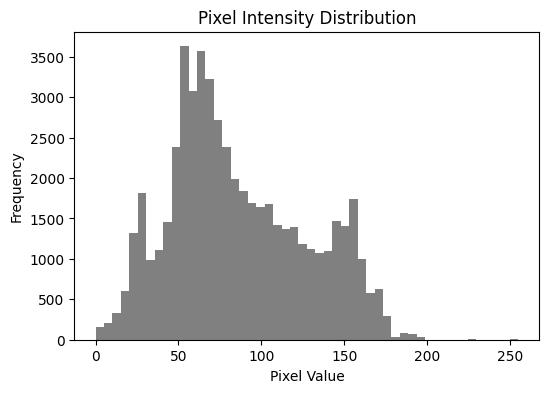

In [8]:
import numpy as np

sample_path = df.sample(1)['file_path'].values[0]
img = Image.open(sample_path).convert('L')
img_array = np.array(img)

plt.figure(figsize=(6,4))
plt.hist(img_array.flatten(), bins=50, color='gray')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


## Data Preprocessing

## Image Resizing (Standardization)

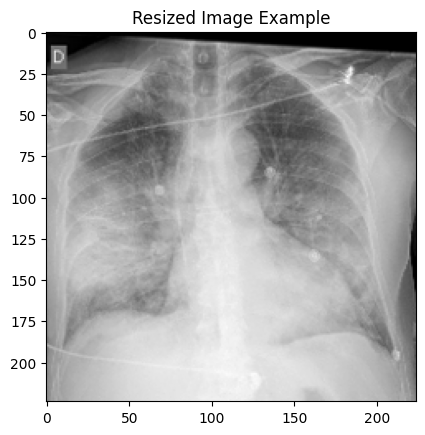

In [9]:
img_size = (224, 224)

def resize_image(path):
    img = Image.open(path).convert('L')  # Grayscale conversion
    img = img.resize(img_size)
    return np.array(img)

# Example for one image
sample_img = resize_image(df['file_path'].iloc[0])
plt.imshow(sample_img, cmap='gray')
plt.title("Resized Image Example")
plt.show()


## Normalization of Pixel Values

In [10]:
img_normalized = sample_img / 255.0  #  scaling to [0, 1]

## Class Weights Calculation (To Handle Imbalance)

In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_names = df['labels'].unique()
class_weights = compute_class_weight(class_weight='balanced', classes=class_names, y=df['labels'])

weights = dict(zip(class_names, class_weights))
print(weights)


{'COVID': np.float64(1.071750717507175), 'NORMAL': np.float64(0.9670736219015909), 'PNEUMONIA': np.float64(0.9681481481481482)}


## Data Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)


In [13]:

# Parameters
img_size = (224, 224)
batch_size = 32

train_df, test_df = train_test_split(df, stratify=df['labels'], test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['labels'], test_size=0.1, random_state=42)

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='labels',
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

val_gen = test_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='labels',
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_gen = test_val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='labels',
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

# Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['labels']),
    y=train_df['labels']
)
weights = dict(zip(np.unique(df['labels']), class_weights))
print("Class Weights:", weights)


Found 3763 validated image filenames belonging to 3 classes.
Found 419 validated image filenames belonging to 3 classes.
Found 1046 validated image filenames belonging to 3 classes.
Class Weights: {'COVID': np.float64(1.0711642470822658), 'NORMAL': np.float64(0.9678497942386831), 'PNEUMONIA': np.float64(0.9678497942386831)}


In [14]:
model = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 1)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,771 (42.61 MB)

 Trainable params: 11,168,771 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    class_weight=weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 46s 329ms/step - accuracy: 0.5971 - loss: 0.9728 - val_accuracy: 0.8735 - val_loss: 0.3398
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 304ms/step - accuracy: 0.8552 - loss: 0.4034 - val_accuracy: 0.8735 - val_loss: 0.3042
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 296ms/step - accuracy: 0.8764 - loss: 0.3647 - val_accuracy: 0.8998 - val_loss: 0.2260
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 287ms/step - accuracy: 0.8947 - loss: 0.2841 - val_accuracy: 0.9236 - val_loss: 0.2144
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 295ms/step - accuracy: 0.9148 - loss: 0.2624 - val_accuracy: 0.9379 - val_loss: 0.1665
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 287ms/step - accuracy: 0.9117 - loss: 0.2575 - val_accuracy: 0.9141 - val_loss: 0.2046
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 293ms/step - accuracy: 0.9108 - loss: 0.2559 - val_accuracy: 0.9260 - val_loss: 0.1937
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 292ms/step - accuracy: 0.9178 - loss: 0

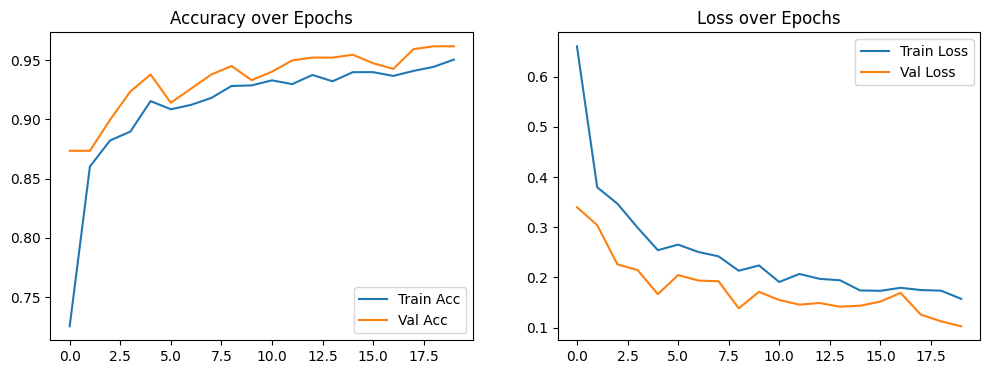

In [16]:
# Accuracy and loss curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()


In [17]:
def get_predictions(model, generator):
    """
    Generates predicted labels and true labels from a Keras generator.
    """
    Y_pred = model.predict(generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())

    return y_true, y_pred, class_labels


def plot_confusion_matrix(y_true, y_pred, class_labels, normalize=False):
    """
    Plots the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalize else None)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.show()


def print_classification_report(y_true, y_pred, class_labels):
    """
    Prints the classification report with precision, recall, f1-score.
    """
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print(report)


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step


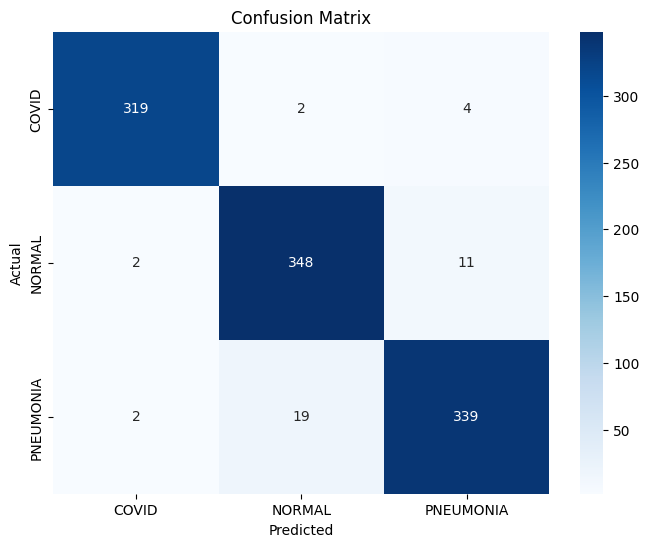

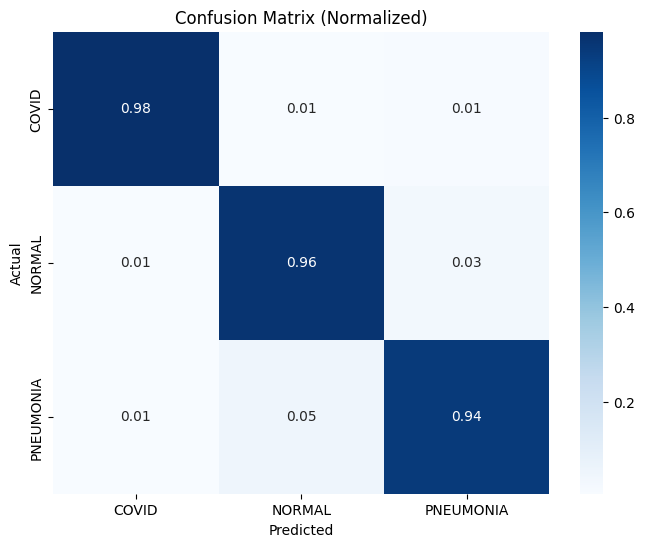

              precision    recall  f1-score   support

       COVID       0.99      0.98      0.98       325
      NORMAL       0.94      0.96      0.95       361
   PNEUMONIA       0.96      0.94      0.95       360

    accuracy                           0.96      1046
   macro avg       0.96      0.96      0.96      1046
weighted avg       0.96      0.96      0.96      1046



In [18]:
from sklearn.metrics import classification_report, confusion_matrix
# Get true and predicted labels
y_true, y_pred, class_labels = get_predictions(model, test_gen)

# Confusion Matrix
plot_confusion_matrix(y_true, y_pred, class_labels)
plot_confusion_matrix(y_true, y_pred, class_labels, normalize=True)

# Classification Report
print_classification_report(y_true, y_pred, class_labels)


In [19]:
from tensorflow.keras.applications import EfficientNetV2B0

def build_efficientnetv2(input_shape=(224, 224, 3), num_classes=3):
    base_model = EfficientNetV2B0(include_top=False, input_shape=input_shape, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False  # Freeze base

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [20]:
# Update your generator for VGG16
train_gen_vgg = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='labels',
    target_size=img_size,
    color_mode='rgb',  # Change to RGB
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

val_gen_vgg = test_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='labels',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 3763 validated image filenames belonging to 3 classes.
Found 419 validated image filenames belonging to 3 classes.


In [21]:
from tensorflow.keras.applications import MobileNetV2

def build_mobilenetv2(input_shape=(224, 224, 3), num_classes=3):
    base_model = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False  # Freeze base

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [22]:
# EfficientNetV2B0
eff_model = build_efficientnetv2(input_shape=(224, 224, 3), num_classes=len(train_gen.class_indices))

history_eff = eff_model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=weights
)


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 84s 478ms/step - accuracy: 0.3247 - loss: 1.1205 - val_accuracy: 0.3461 - val_loss: 1.1024
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 287ms/step - accuracy: 0.3431 - loss: 1.1178 - val_accuracy: 0.4821 - val_loss: 1.0864
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 276ms/step - accuracy: 0.3311 - loss: 1.1104 - val_accuracy: 0.3461 - val_loss: 1.0890
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 283ms/step - accuracy: 0.3512 - loss: 1.1012 - val_accuracy: 0.4344 - val_loss: 1.0799
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - accuracy: 0.3723 - loss: 1.1018 - val_accuracy: 0.3270 - val_loss: 1.0888
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 289ms/step - accuracy: 0.3946 - loss: 1.0890 - val_accuracy: 0.3461 - val_loss: 1.0750
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 277ms/step - accuracy: 0.3544 - loss: 1.1021 - val_accuracy: 0.3819 - val_loss: 1.0729
Epoch 8/15
118/118 ━━━━━━━━━━━━━

In [23]:
from tensorflow.keras.applications import VGG16

def build_vgg16(input_shape=(224, 224, 3), num_classes=3):
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
  for layer in base_model.layers:
        layer.trainable = False  # Freeze base layers

  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.3)(x)
  output = layers.Dense(num_classes, activation='softmax')(x)
  model = models.Model(inputs=base_model.input, outputs=output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [24]:
vgg_model = build_vgg16(input_shape=(224, 224, 3), num_classes=len(train_gen.class_indices))

history_vgg = vgg_model.fit(
    train_gen_vgg,
    epochs=15,
    validation_data=val_gen_vgg,
    class_weight=weights
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 95s 694ms/step - accuracy: 0.4352 - loss: 1.0739 - val_accuracy: 0.8115 - val_loss: 0.8110
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 611ms/step - accuracy: 0.7330 - loss: 0.7927 - val_accuracy: 0.8425 - val_loss: 0.6651
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 71s 599ms/step - accuracy: 0.7926 - loss: 0.6647 - val_accuracy: 0.8496 - val_loss: 0.5878
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 609ms/step - accuracy: 0.8175 - loss: 0.5999 - val_accuracy: 0.8544 - val_loss: 0.5308
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 616ms/step - accuracy: 0.8325 - loss: 0.5414 - val_accuracy: 0.8711 - val_loss: 0.4816
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 71s 603ms/step - accuracy: 0.8374 - loss: 0.5171 - val_accuracy: 0.8831 - val_loss: 0.4430
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 71s 604ms/step - accuracy: 0.8433 - loss: 0.4820 - val_accuracy: 0.8735 - val_loss: 0.4251
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 614ms/step - accuracy: 0.8623 - loss: 0

EfficientNetV2B0 Evaluation:
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 385ms/step


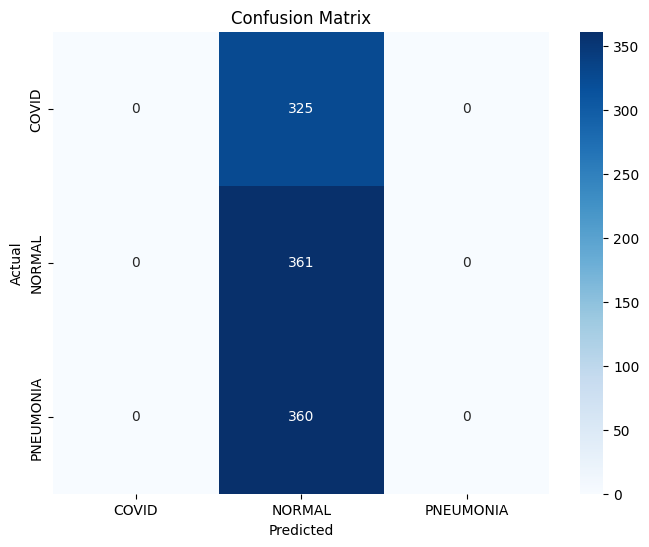

              precision    recall  f1-score   support

       COVID       0.00      0.00      0.00       325
      NORMAL       0.35      1.00      0.51       361
   PNEUMONIA       0.00      0.00      0.00       360

    accuracy                           0.35      1046
   macro avg       0.12      0.33      0.17      1046
weighted avg       0.12      0.35      0.18      1046



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
print("EfficientNetV2B0 Evaluation:")
y_true, y_pred, class_labels = get_predictions(eff_model, test_gen)
plot_confusion_matrix(y_true, y_pred, class_labels)
print_classification_report(y_true, y_pred, class_labels)

VGG16 Evaluation:
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step


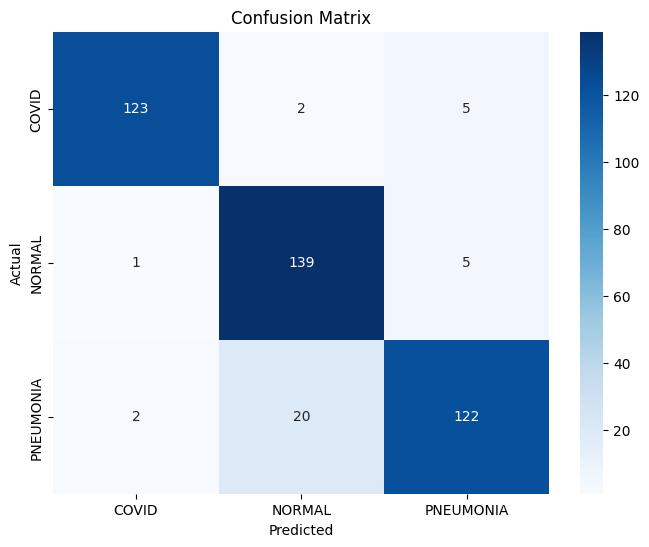

              precision    recall  f1-score   support

       COVID       0.98      0.95      0.96       130
      NORMAL       0.86      0.96      0.91       145
   PNEUMONIA       0.92      0.85      0.88       144

    accuracy                           0.92       419
   macro avg       0.92      0.92      0.92       419
weighted avg       0.92      0.92      0.92       419



In [26]:
print("VGG16 Evaluation:")
y_true, y_pred, class_labels = get_predictions(vgg_model, val_gen_vgg)
plot_confusion_matrix(y_true, y_pred, class_labels)
print_classification_report(y_true, y_pred, class_labels)